In [43]:
!pip install geodatasets

In [44]:
#Installing geographical mapping software thing
!conda install geopandas -y

Jupyter detected...
2 channel Terms of Service accepted
Channels:
 - defaults
Platform: osx-arm64
doneecting package metadata (repodata.json): - 
doneing environment: - 


==> WARNING: A newer version of conda exists. <==
    current version: 25.5.1
    latest version: 25.11.1

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [45]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely import wkt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib as mpl
import matplotlib.patheffects as PathEffects
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mticker
sns.set_theme()

In [46]:
df = pd.read_csv('full_dataset.csv')

In [47]:
# Changing columns to names I understand.
df_cleaned = df.rename(columns={
    'y_': 'Fished',
    'length': 'Length (m)',
    'weight': 'Catch_Weight (kg)',
    'patch': 'Patch_ID',
    'dist': 'Distance_To_Shore',
    'patch_area': 'Patch_Area (km²)',
    'surf_temp': 'Surface_Temp (K)',
    'power': 'Metric_Horsepower',
    'ID': 'Vessel_ID',
    'landing': 'Landing',
    'year': 'Year',
    'engine_age': 'Engine_Age (Yrs)',
    'value_cpi': 'Val_Inf_Adj (NOK)',
    'y_month': 'Month'
})

# Switch K to C for surface temps
df_cleaned['Surface_Temp (C)'] = df_cleaned['Surface_Temp (K)'] - 273.15
df_cleaned = df_cleaned.drop(columns=['Surface_Temp (K)'])

# Getting rid of columns I won't be using.
df_cleaned = df_cleaned.drop(columns=[
    'weight_lym', 'weight_lm', 'val_lm', 'val_lym'
], errors='ignore')

# Cleaning up year column
df_cleaned['Year'] = df_cleaned['Year'].apply(lambda x: 2000 + int(x))





# Change fished or not 1/0 to yes/no
df_cleaned['Fished'] = df_cleaned['Fished'].map({1: 'Yes', 0: 'No'})

In [48]:
# List of U.S. dollar to Norwegian Krone exchange rates from 2001 - 2019 I got from Bank of England historical website
exchange_rates = {
    2001: 1/8.8,
    2002: 1/9,
    2003: 1/6.9,
    2004: 1/6.8,
    2005: 1/6.3,
    2006: 1/6.6,
    2007: 1/6.4,
    2008: 1/5.4,
    2009: 1/7,
    2010: 1/5.7,
    2011: 1/6,
    2012: 1/6,
    2013: 1/5.6,
    2014: 1/6.2,
    2015: 1/7.7,
    2016: 1/8.8,
    2017: 1/8.5,
    2018: 1/7.9,
    2019: 1/8.5
}
# Multiplied each inflation adjusted Krone value by exchange rates to get inflation adjusted dollar value
df_cleaned['Val_Inf_Adj (USD)'] = df_cleaned.apply(lambda row: row['Val_Inf_Adj (NOK)'] * exchange_rates[row['Year']], axis=1)

In [49]:
# shifting months to be 1-12 and not 0-11
df_cleaned['Month'] = df_cleaned['Month'].astype(int) + 1

# month names
import calendar
df_cleaned['Month_Name'] = df_cleaned['Month'].apply(lambda x: calendar.month_name[x])


In [50]:
# Reordering columns
cols = ['Fished', 'Catch_Weight (kg)', 'Val_Inf_Adj (USD)', 'Val_Inf_Adj (NOK)', 'Engine_Age (Yrs)', 'Length (m)', 'Metric_Horsepower',
         'Month', 'Month_Name', 'Year', 'Patch_ID', 'Distance_To_Shore', 
        'Patch_Area (km²)', 'nao_index', 'Surface_Temp (C)', 'Landing', 'Vessel_ID',]
df_cleaned = df_cleaned[[c for c in cols if c in df_cleaned.columns]]

In [51]:
df_cleaned

,Fished,Catch_Weight (kg),Val_Inf_Adj (USD),Val_Inf_Adj (NOK),Engine_Age (Yrs),Length (m),Metric_Horsepower,Month,Month_Name,Year,Patch_ID,Distance_To_Shore,Patch_Area (km²),nao_index,Surface_Temp (C),Landing,Vessel_ID
0,Yes,5.0,17.336232,119.62,10.0,10.50,367.0,9,September,2003,09-16,13.6,3229,-0.070,13.75,RISØR,1993001257
1,Yes,19.0,107.314035,611.69,26.0,21.30,970.0,12,December,2010,03-03,59.6,2122,-1.616,3.10,BÅTSFJORD,1993005128
2,No,0.0,0.000000,0.00,32.0,12.13,190.0,3,March,2014,04-27,286.7,4596,1.335,5.88,ØKSNES,1996007882
3,No,0.0,0.000000,0.00,8.0,27.45,1014.0,6,June,2007,42-72,461.5,3038,0.664,9.07,AVERØY,1999009281
4,Yes,12.5,97.393671,769.41,31.0,9.22,80.0,1,January,2018,06-23,40.2,2555,0.882,11.10,BRØNNØY,1986007228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1601865,No,0.0,0.000000,0.00,15.0,14.99,300.0,2,February,2005,03-03,695.6,2122,1.520,6.71,VÅGAN,1996008267
1601866,No,0.0,0.000000,0.00,34.0,19.01,370.0,4,April,2003,05-20,53.7,2520,0.320,6.67,VÅGAN,1976006330
1601867,Yes,1.5,3.628070,20.68,3.0,7.00,144.0,5,May,2010,08-15,10.6,1418,-0.720,14.20,BØMLO,2007039109
1601868,No,0.0,0.000000,0.00,9.0,14.16,291.0,2,February,2010,07-26,457.5,5377,-1.109,6.16,RØST,2001015121


In [52]:
#Data has been cleaned, now ready for interpretation / presentation 






Average catch weight per year (kg):
2001: 9533 kg
2002: 2111 kg
2003: 8290 kg
2004: 8034 kg
2005: 6980 kg
2006: 6881 kg
2007: 7242 kg
2008: 6613 kg
2009: 7084 kg
2010: 7364 kg
2011: 6431 kg
2012: 5011 kg
2013: 5394 kg
2014: 6693 kg
2015: 7269 kg
2016: 5102 kg
2017: 5992 kg
2018: 8434 kg


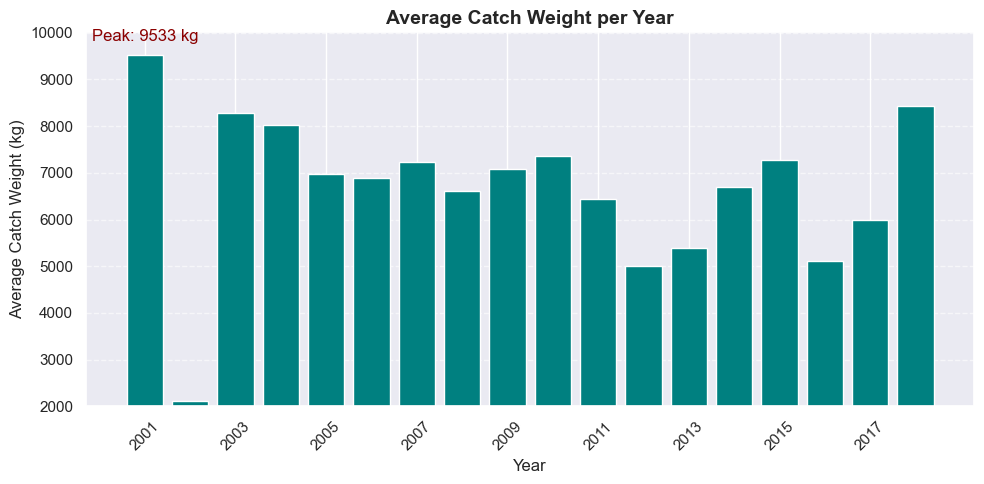

In [53]:
# Used a for loop for a bar chart of avg. catches per year by weight


# avg of each year's catch weight
avg_catch_by_year = df_cleaned.groupby('Year')['Catch_Weight (kg)'].mean()

# loop for each year
print("Average catch weight per year (kg):")
for year, weight in avg_catch_by_year.items():
    print(f"{year}: {weight:.0f} kg")

# bar chart of results
plt.figure(figsize=(10,5))
bars = plt.bar(avg_catch_by_year.index.astype(int), avg_catch_by_year.values, color='teal')

# cosmetic stuff
plt.title("Average Catch Weight per Year", fontsize=14, fontweight='bold')
plt.xlabel("Year")
plt.ylabel("Average Catch Weight (kg)")

xticks = list(range(int(avg_catch_by_year.index.min()), int(avg_catch_by_year.index.max())+1, 2))
plt.xticks(xticks, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.ylim(2000, None)

# peak
max_year = avg_catch_by_year.idxmax()
max_val = avg_catch_by_year.max()
plt.text(max_year, max_val + 300, f"Peak: {max_val:.0f} kg", ha='center', color='darkred')

plt.tight_layout()
plt.show()

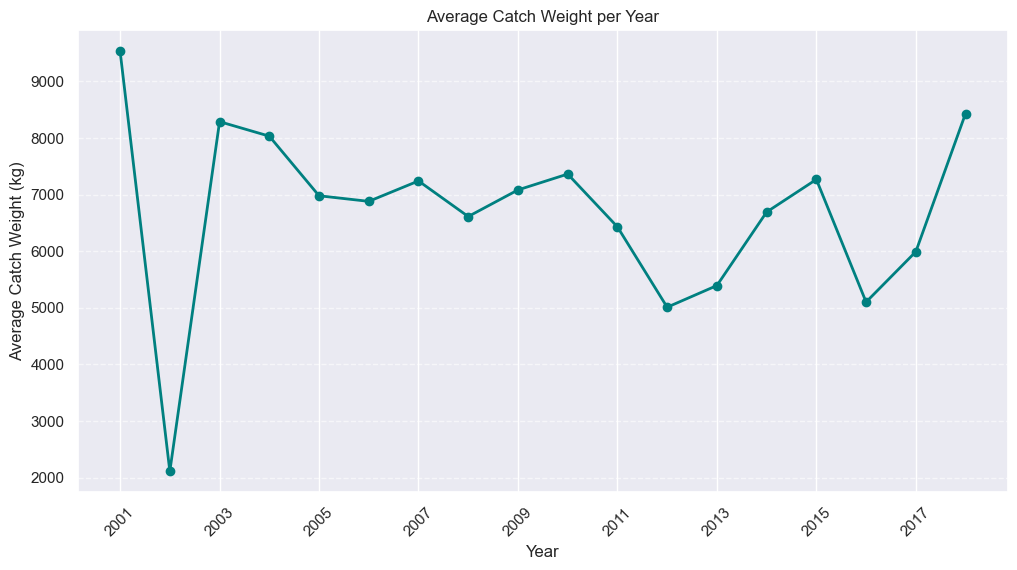

In [54]:
#Line chart of avg catch by year
#For whatever reason, there was a gap in data from March-December in 2002, which makes the data seem really low for that year. Could be 
#related to the 2002 Bow Eagle Norwegian boat crash causing casualties I looked up, but that didn't occur until August 2002, so I'm not sure


plt.figure(figsize=(12,6))
plt.plot(avg_catch_by_year.index, avg_catch_by_year.values, marker='o', color='teal', linewidth=2)
plt.title("Average Catch Weight per Year")
plt.xlabel("Year")
plt.ylabel("Average Catch Weight (kg)")
plt.xticks(xticks, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [ ]:
df_cleaned.to_csv("df_cleaned.csv", index=False)

In [59]:
df_cleaned = pd.read_csv("df_cleaned.csv")

# Loads in the "raster" dataset, which here is a map of the ocean patches that they recorded this fishing data in. I can like map the fishing
# data I've finally finished cleaning onto this map of patches to display it rly obiously
raster = pd.read_csv("raster.csv")
raster['geometry'] = raster['geometry'].apply(wkt.loads)  
# the raster was in wkt, which is like a text-only way to describe the map, so I converted it to polygon shapes 
raster = gpd.GeoDataFrame(raster, geometry='geometry')

# should put the coastlines of surrounding countries in, I'm gonna use the ones where I've seen ships go in the dataset
world = gpd.read_file("ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
co = world[world['NAME'].isin(["United Kingdom", "Iceland", "Finland", "Netherlands", "Belgium", "Norway", "Ireland", "Poland", "Denmark", "Sweden"])]

# plotting catch weight data from August 2010 in this one
YEAR = 2012
MONTH = 8  
month_data = df_cleaned[(df_cleaned['Year']==YEAR) & (df_cleaned['Month']==MONTH)]

# getting avg weight for each patch
patch_values = month_data.groupby('Patch_ID')['Catch_Weight (kg)'].mean().to_dict()

# putting the values into all the polygons
raster['val'] = raster['LOKREF'].replace(patch_values)  # LOKREF is like the raster patch id 

# plot
fig, ax = plt.subplots(figsize=(10,10))

# Plot raster first with some transparency so countries will show on top
raster.plot(ax=ax, column='val', cmap='PuBu', edgecolor='k', alpha=0.7, legend=False)

# Plot countries on top
co.plot(ax=ax, color='green', edgecolor='black')


raster['val'] = pd.to_numeric(raster['val'], errors='coerce')
raster['val'] = raster['val'].fillna(0)  # optional: replace NaN with 0 for plotting

# Putting in a legend bar for my heatmap 
norm = Normalize(vmin=raster['val'].min(), vmax=raster['val'].max())
sm = ScalarMappable(norm=norm, cmap='PuBu')
sm._A = [] 
cbar = fig.colorbar(sm, ax=ax, shrink=0.5)
cbar.set_label("Average Catch Weight (kg)", fontsize=12)

#testing stuff out

plt.title(f"Average Catch Weight by Patch - {MONTH}/{YEAR}", fontsize=14, fontweight='bold')

#making it fit snug in the box
bounds = raster.total_bounds
ax.set_xlim(bounds[0] - 1, bounds[2] + 1) 
ax.set_ylim(bounds[1] - 1, bounds[3] + 1)

ax.set_xlabel("Longitude (°)", fontsize=12)
ax.set_ylabel("Latitude (°)", fontsize=13)

plt.show()

KeyError: 'NAME'

In [ ]:
#
#
#
#
#

In [ ]:
df_cleaned = pd.read_csv("df_cleaned.csv")

# Loads in the "raster" dataset, which here is a map of the ocean patches that they recorded this fishing data in. I can like map the fishing
# data I've finally finished cleaning onto this map of patches to display it rly obiously
raster = pd.read_csv("raster.csv")
raster['geometry'] = raster['geometry'].apply(wkt.loads)  
# the raster was in wkt, which is like a text-only way to describe the map, so I converted it to polygon shapes 
raster = gpd.GeoDataFrame(raster, geometry='geometry')

# should put the coastlines of surrounding countries in, I'm gonna use the ones where I've seen ships go in the dataset
world = gpd.read_file("ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
co = world[world['NAME'].isin(["United Kingdom", "Austria", "Czech Republic", "France", "Germany", "Luxembourg", "Switzerland", "Belarus", "Ukraine", "Greenland", "Estonia", "Latvia", "Russia", "Iceland", "Finland", "Netherlands", "Belgium", "Norway", "Ireland", "Poland", "Denmark", "Sweden"])]

# plotting catch weight data from August 2010 in this one
YEAR = 2012
MONTH = 8  
month_data = df_cleaned[(df_cleaned['Year']==YEAR) & (df_cleaned['Month']==MONTH)]

# getting avg weight for each patch
patch_values = month_data.groupby('Patch_ID')['Catch_Weight (kg)'].mean().to_dict()

# putting the values into all the polygons
raster['val'] = raster['LOKREF'].replace(patch_values)  # LOKREF is like the raster patch id 

# plot
fig, ax = plt.subplots(figsize=(12,12))

# Plot raster first with some transparency so countries will show on top
raster.plot(ax=ax, column='val', cmap='PuBu', edgecolor='k', alpha=0.7, legend=False)

# Plot countries on top
co.plot(ax=ax, color=(0.0, 0.25, 0.0), edgecolor='black')
for idx, row in co.iterrows():
    txt = plt.text(row['geometry'].centroid.x, row['geometry'].centroid.y, 
                   row['NAME'], 
                   fontsize=9,
                   fontname='Times New Roman',
                   ha='center', 
                   va='center',
                   color='white')
    # Add a white outline
    txt.set_path_effects([PathEffects.withStroke(linewidth=0.5, foreground='black')])

raster['val'] = pd.to_numeric(raster['val'], errors='coerce')
raster['val'] = raster['val'].fillna(0)  # optional: replace NaN with 0 for plotting

# Putting in a legend bar for my heatmap 
norm = Normalize(vmin=raster['val'].min(), vmax=raster['val'].max())
sm = ScalarMappable(norm=norm, cmap='PuBu')
sm._A = [] 
cbar = fig.colorbar(sm, ax=ax, shrink=0.5)
cbar.set_label("Average Catch Weight (kg)", fontsize=12)

#testing stuff out

plt.title(f"Average Catch Weight by Patch - {MONTH}/{YEAR}", fontsize=14, fontweight='bold')

#making it fit snug in the box
bounds = raster.total_bounds
ax.set_xlim(bounds[0] - 1, bounds[2] + 1) 
ax.set_ylim(bounds[1] - 1, bounds[3] + 1)

ax.set_xlabel("Longitude (°)", fontsize=12)
ax.set_ylabel("Latitude (°)", fontsize=13)

plt.show()

In [ ]:
#how many boats in the data set
unique_vessels = df_cleaned['Vessel_ID'].nunique()
print(f"Number of unique vessels: {unique_vessels}")

In [ ]:
#how many data entries
total_entries = len(df_cleaned)
print(f"Total entries in the dataset: {total_entries}")

In [ ]:
num_rows = df_cleaned.shape[0]
print("Number of rows:", num_rows)

In [ ]:
df_cleaned.shape

In [ ]:
df_cleaned.columns

In [ ]:
num_rows = len(df_cleaned)
print(f"Total rows: {num_rows}")

In [ ]:
unique_patch_months = df_cleaned.groupby(['Patch_ID', 'Year', 'Month']).ngroups
print(f"Unique patch × month combinations: {unique_patch_months}")

In [ ]:
unique_obs = df_cleaned.groupby(['Patch_ID','Vessel_ID','Year','Month','Catch_Weight (kg)']).ngroups
print(f"Approx. unique observations: {unique_obs}")

In [ ]:
# Base map of all the patches without the fishing data put into it, for my dataset slide, putting in countries too for clarity


# get the raster data
df_cleaned = pd.read_csv("df_cleaned.csv")
raster = pd.read_csv("raster.csv")
raster['geometry'] = raster['geometry'].apply(wkt.loads)
raster = gpd.GeoDataFrame(raster, geometry='geometry')

# get the map data
world = gpd.read_file("ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
co = world[world['NAME'].isin([
    "United Kingdom", "Austria", "Czech Republic", "France", "Germany", 
    "Luxembourg", "Switzerland", "Belarus", "Ukraine", "Greenland", 
    "Estonia", "Latvia", "Russia", "Iceland", "Finland", "Netherlands", 
    "Belgium", "Norway", "Ireland", "Poland", "Denmark", "Sweden"
])]

fig, ax = plt.subplots(figsize=(12,12))

raster.plot(ax=ax, facecolor="none", edgecolor='k')
co.plot(ax=ax, color=(0.0, 0.25, 0.0), edgecolor='black')

# putting names on the countries
for idx, row in co.iterrows():
    x = row['geometry'].centroid.x
    y = row['geometry'].centroid.y
 
    # manually shiftign all the countries that aren't in the right spot or are hard to read
    if row['NAME'] == "Norway":
        x -= 7.0   
        y -= 8.0   
    if row['NAME'] == "Sweden":
        x += 2.0   
        y += 3.0  
    if row['NAME'] == "Finland":
        x += 0.0   
        y -= 2.0  
    if row['NAME'] == "Estonia":
        x += 0.75   
        y -= 0.0
    if row['NAME'] == "Latvia":
        x += 1.0   
        y -= 0.0
    if row['NAME'] == "United Kingdom":
        x += 0.0   
        y += 3.0    
    if row['NAME'] == "Russia":
        x -= 50.0   
        y -= 4.0   
    if row['NAME'] == "France":
        x += 4.5   
        y += 6.0
    if row['NAME'] == "Switzerland":
        x += 0.0   
        y += 1.0
    if row['NAME'] == "Austria":
        x += 1.0   
        y += 0.3
    if row['NAME'] == "Greenland":
        x += 3.0   
        y += 0.0
        

    txt = plt.text(x, y, 
                   row['NAME'], 
                   fontsize=9,
                   fontname='Times New Roman',
                   ha='center', 
                   va='center',
                   color='white',
                   fontweight = 'bold')
    txt.set_path_effects([PathEffects.withStroke(linewidth=0.5, foreground='black')])

# make the graph fit tighter in the box
bounds = raster.total_bounds
ax.set_xlim(bounds[0] - 1, bounds[2] + 1) 
ax.set_ylim(bounds[1] - 1, bounds[3] + 1)

# lat and long labels for my axes
ax.set_xlabel("Longitude (°)", fontsize=12)
ax.set_ylabel("Latitude (°)", fontsize=13)
plt.title("Map of North Atlantic Fishing Patches", fontsize=14, fontweight='bold')

plt.show()

In [ ]:
corr = df_cleaned[['Catch_Weight (kg)', 'Val_Inf_Adj (USD)', 
           'Engine_Age (Yrs)', 'Length (m)', 'Metric_Horsepower']].corr()

corr

In [ ]:
by_length = df_cleaned.groupby('Length (m)')['Catch_Weight (kg)'].mean()
by_engine_age = df_cleaned.groupby('Engine_Age (Yrs)')['Catch_Weight (kg)'].mean()
by_horsepower = df_cleaned.groupby('Metric_Horsepower')['Catch_Weight (kg)'].mean()

best_length = by_length.idxmax()
best_length_catch = by_length.max()

best_engine_age = by_engine_age.idxmax()
best_engine_age_catch = by_engine_age.max()

best_horsepower = by_horsepower.idxmax()
best_horsepower_catch = by_horsepower.max()

print(f"Best boat length: {best_length} m (avg catch = {best_length_catch:.2f} kg)")
print(f"Best engine age: {best_engine_age} years (avg catch = {best_engine_age_catch:.2f} kg)")
print(f"Best horsepower: {best_horsepower} HP (avg catch = {best_horsepower_catch:.2f} kg)")

In [ ]:
# this is the best possible boat specs, but it's thrown off bc of one outlier datapoint of this like 30 yr old boat
combo_stats = (
    df_cleaned.groupby(['Length (m)', 'Engine_Age (Yrs)', 'Metric_Horsepower'])['Catch_Weight (kg)']
    .mean()
    .reset_index()
)

best_combo = combo_stats.loc[combo_stats['Catch_Weight (kg)'].idxmax()]
print(best_combo)

In [ ]:
# this is the best performing ship in the entire dataset
combo = (74.6, 30.0, 6000.0)
df_cleaned[
    (df_cleaned['Length (m)'] == combo[0]) &
    (df_cleaned['Engine_Age (Yrs)'] == combo[1]) &
    (df_cleaned['Metric_Horsepower'] == combo[2])
]

In [ ]:
combo_stats = (
    df_cleaned.groupby(['Length (m)', 'Engine_Age (Yrs)', 'Metric_Horsepower'])['Catch_Weight (kg)']
    .agg(['mean', 'count'])
    .reset_index()
)

# combos that appear at least 10 times
filtered = combo_stats[combo_stats['count'] >= 10]

#combo with highest mean catch
best_combo = filtered.loc[filtered['mean'].idxmax()]
best_combo

In [ ]:
vessel_best = df_cleaned[df_cleaned['Vessel_ID'] == 1993003818]
vessel_best_rounded = vessel_best.round(2)
for col in vessel_best_rounded.select_dtypes(include='number').columns:
    vessel_best_rounded[col] = vessel_best_rounded[col].apply(lambda x: f"{x:,.2f}")
display(vessel_best_rounded)
total_catch = vessel_best['Catch_Weight (kg)'].sum()
avg_catch = vessel_best['Catch_Weight (kg)'].mean()
print("Total Catch Weight (kg):", f"{total_catch:,.2f}")
print("Average Catch Weight (kg):", f"{avg_catch:,.2f}")
print("Total Trips Recorded:", len(vessel_best))
print("Years Active:", vessel_best['Year'].min(), "-", vessel_best['Year'].max())

In [ ]:
best_combo = df_cleaned.groupby(['Length (m)', 'Metric_Horsepower'])['Catch_Weight (kg)'].mean().reset_index()
best_performer = best_combo.loc[best_combo['Catch_Weight (kg)'].idxmax()]
best_performer

In [ ]:
#new dataframe for the best ship

best_vessel_id = 1993003818

best_vessel_df = df_cleaned[df_cleaned['Vessel_ID'] == best_vessel_id][[
    'Catch_Weight (kg)',
    'Val_Inf_Adj (USD)',
    'Length (m)',
    'Engine_Age (Yrs)',
    'Metric_Horsepower',
]].copy()

best_vessel_df = best_vessel_df.rename(columns={
    'Catch_Weight (kg)': 'Catch Weight (kg)',
    'Val_Inf_Adj (USD)': 'Catch Value (USD)',
    'Length (m)': 'Hull Length (m)',
    'Engine_Age (Yrs)': 'Engine Age (Years)',
    'Metric_Horsepower': 'Metric Horsepower'
})
best_vessel_df.reset_index(drop=True, inplace=True)
best_vessel_df

In [ ]:
avg_best_vessel = best_vessel_df.mean().round(2)
avg_best_vessel

In [ ]:
best_vessel_top5 = best_vessel_df.nlargest(5, 'Catch Weight (kg)').copy()
best_vessel_top5['Catch Weight (Tons)'] = (best_vessel_top5['Catch Weight (kg)'] / 1000).round(1)
best_vessel_top5['Catch Value (USD)'] = best_vessel_top5['Catch Value (USD)'].round(1)
best_vessel_top5 = best_vessel_top5.drop(columns=['Catch Weight (kg)'])
cols = ['Catch Weight (Tons)', 'Catch Value (USD)', 'Hull Length (m)', 'Engine Age (Years)', 'Metric Horsepower']
best_vessel_top5 = best_vessel_top5[cols]
best_vessel_top5

In [ ]:
best_vessel_top5_sorted = best_vessel_top5.sort_values('Engine Age (Years)').reset_index(drop=True)
fig, ax = plt.subplots(figsize=(8,2.5))
ax.axis('off')
tbl = ax.table(cellText=best_vessel_top5_sorted.values,
               colLabels=best_vessel_top5_sorted.columns,
               cellLoc='center',
               loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
for key, cell in tbl.get_celld().items():
    if key[1] == 0:
        cell.set_width(0.25)
tbl.scale(1, 1.3)
fig.suptitle("Top 5 Catches By The Most Effective Vessel",
             fontsize=12, fontweight='bold', ha='center', va='bottom', y=0.8, fontname='Times New Roman')
plt.show()

In [ ]:
best_vessel_top5_sorted = best_vessel_top5.sort_values('Engine Age (Years)').reset_index(drop=True)
fig, ax = plt.subplots(figsize=(8,2.5), facecolor=(12/255, 83/255, 149/255))
ax.set_facecolor((12/255, 83/255, 149/255))
ax.axis('off')
tbl = ax.table(cellText=best_vessel_top5_sorted.values,
               colLabels=best_vessel_top5_sorted.columns,
               cellLoc='center',
               loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
for key, cell in tbl.get_celld().items():
    cell.set_facecolor((12/255, 83/255, 149/255))
    cell.set_text_props(color='white', fontname='Times New Roman')
    if key[1] == 0:
        cell.set_width(0.25)
tbl.scale(1, 1.3)
fig.suptitle("Top 5 Catches By The Most Effective Vessel",
             fontsize=12, fontweight='bold', ha='center', va='bottom', y=0.8, fontname='Times New Roman')
plt.show()

In [ ]:
# this is the best combo of the three that you could make, excluding stupid outliers 

combo_stats = (
    df_cleaned.groupby(['Length (m)', 'Engine_Age (Yrs)', 'Metric_Horsepower'])['Catch_Weight (kg)']
    .agg(['mean', 'count'])
    .reset_index()
)

# combos that appear at least 10 times
filtered = combo_stats[combo_stats['count'] >= 10]

#combo with highest mean catch
best_combo = filtered.loc[filtered['mean'].idxmax()]
best_combo

In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'

fig = plt.figure(figsize=(10,8), facecolor='#f5f5f5')
ax = fig.add_subplot(111, projection='3d', facecolor='#f5f5f5')

scatter = ax.scatter(
    combo_stats['Length (m)'], 
    combo_stats['Metric_Horsepower'], 
    combo_stats['mean']/1000, 
    c=combo_stats['mean']/1000, 
    cmap='YlGnBu',
    s=50, 
    edgecolors='black', 
    linewidths=0.5, 
    depthshade=True
)

ax.set_xlabel('Length (m)')
ax.set_ylabel('Metric Horsepower (PS)')
ax.set_zlabel('Average Catch Weight (Tons)')
ax.set_title('Vessel Specs vs. Average Catch Weight', fontsize=16, fontweight='bold', ha='center', va='bottom', y=1.0)

ax.set_xlim(ax.get_xlim()[::-1])

ax.scatter(
    best_combo['Length (m)'], 
    best_combo['Metric_Horsepower'], 
    best_combo['mean']/1000 + 110,
    color='#00008B', 
    s=80, 
    edgecolors='black', 
    linewidths=1.5, 
    label='Best Combo'
)

cbar = fig.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label('Average Catch Weight (Tons)')
cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.1f}'))
plt.show()

In [ ]:
# the 1st of 2 df display tables i'll use

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.color'] = 'white'

df_nozero = df_cleaned.rename(columns={
    'Fished': 'Fished',
    'Catch_Weight (kg)': 'Catch Weight (Tons)',
    'Val_Inf_Adj (USD)': 'Catch Value (USD)',
    'Engine_Age (Yrs)': 'Engine Age (Years)',
    'Length (m)': 'Hull Length (m)',
    'Metric_Horsepower': 'Metric Horsepower',
    'Month': 'Month',
    'Month_Name': 'Month Name',
    'Year': 'Year',
    'Patch_ID': 'Patch ID',
    'Patch_Area (km²)': 'Patch Area (km²)',
    'nao_index': 'NAO Index',
    'Surface_Temp (C)': 'Surface Temp (°C)',
    'Landing': 'Landing',
    'Vessel_ID': 'Vessel ID'
})

df_nozero['Catch Weight (Tons)'] = df_nozero['Catch Weight (Tons)'] / 1000
df_nozero = df_nozero[df_nozero['Catch Weight (Tons)'] > 0.5]
df_nozero = df_nozero[df_nozero['Catch Value (USD)'] > 0]
df_nozero = df_nozero[df_nozero['Engine Age (Years)'] < 50]

df_nozero_cleaned = df_nozero.drop(columns=['Landing', 'Year', 'Month Name', 'NAO Index', 'Surface Temp (°C)', 'Month', 'Patch Area (km²)', 'Vessel ID', 'Val_Inf_Adj (NOK)', 'Distance_To_Shore'], errors='ignore')

summary_stats = df_nozero_cleaned.describe().round(1)

fig, ax = plt.subplots(figsize=(18,6), facecolor=(12/255, 83/255, 149/255))
ax.set_facecolor((12/255, 83/255, 149/255))
ax.axis('off')

tbl = ax.table(cellText=summary_stats.values,
               colLabels=summary_stats.columns,
               rowLabels=summary_stats.index,
               cellLoc='center',
               loc='center')

tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.5, 2.5)

col_widths = [0.105] * len(summary_stats.columns)
for j, width in enumerate(col_widths):
    for i in range(len(summary_stats.index)+1):
        tbl[i, j].set_width(width)

for key, cell in tbl.get_celld().items():
    cell.set_facecolor((12/255, 83/255, 149/255))
    cell.set_text_props(color='white')

plt.title("Descriptive Statistics of Fishing Dataset (Catch > .5 Tons)", fontsize=18, fontweight='bold', color='white', ha='center', va='bottom', y=1.05)
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.color'] = 'white'

df_deepcleaned_full = df_cleaned.rename(columns={
    'Fished': 'Fished',
    'Catch_Weight (kg)': 'Catch Weight (Tons)',
    'Val_Inf_Adj (USD)': 'Catch Value (USD)',
    'Engine_Age (Yrs)': 'Engine Age (Years)',
    'Length (m)': 'Hull Length (m)',
    'Metric_Horsepower': 'Metric Horsepower',
    'Month': 'Month',
    'Month_Name': 'Month Name',
    'Year': 'Year',
    'Patch_ID': 'Patch ID',
    'Patch_Area (km²)': 'Patch Area (km²)',
    'nao_index': 'NAO Index',
    'Surface_Temp (C)': 'Surface Temp (°C)',
    'Landing': 'Landing',
    'Vessel_ID': 'Vessel ID',
    'Val_Inf_Adj (NOK)': 'Catch Value (NOK)',
    'Distance_To_Shore': 'Distance to Shore (km)'
})

df_deepcleaned_full['Catch Weight (Tons)'] = df_deepcleaned_full['Catch Weight (Tons)'] / 1000

# drop the first 6 columns
cols_to_drop = df_deepcleaned_full.columns[:6]
df_deepcleaned_full = df_deepcleaned_full.drop(columns=cols_to_drop)

# drop Metric Horsepower, Month, and Year
df_deepcleaned_full = df_deepcleaned_full.drop(columns=['Metric Horsepower', 'Month', 'Year', 'Vessel ID'])

summary_stats_full = df_deepcleaned_full.describe().round(1)

fig, ax = plt.subplots(figsize=(18,6), facecolor=(12/255, 83/255, 149/255))
ax.set_facecolor((12/255, 83/255, 149/255))
ax.axis('off')

tbl = ax.table(cellText=summary_stats_full.values,
               colLabels=summary_stats_full.columns,
               rowLabels=summary_stats_full.index,
               cellLoc='center',
               loc='center')

tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.5, 2.5)

col_widths = [0.095] * len(summary_stats_full.columns)
for j, width in enumerate(col_widths):
    for i in range(len(summary_stats_full.index)+1):
        tbl[i, j].set_width(width)

for key, cell in tbl.get_celld().items():
    cell.set_facecolor((12/255, 83/255, 149/255))
    cell.set_text_props(color='white')

plt.title("Descriptive Statistics of Full Fishing Dataset Pt. 2", fontsize=18, fontweight='bold', color='white', ha='center', va='bottom', y=1.05)
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

fig = plt.figure(figsize=(10,8), facecolor=('#0C5395'))
ax = fig.add_subplot(111, projection='3d', facecolor=('#0C5395'))

ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.zaxis.label.set_color('white')
ax.tick_params(colors='white')

scatter = ax.scatter(
    combo_stats['Length (m)'], 
    combo_stats['Metric_Horsepower'], 
    combo_stats['mean']/1000, 
    c=combo_stats['mean']/1000, 
    cmap='YlGnBu',
    s=50, 
    edgecolors='black', 
    linewidths=0.5, 
    depthshade=True
)

ax.set_xlabel('Length (m)')
ax.set_ylabel('Metric Horsepower (PS)')
ax.set_zlabel('Average Catch Weight (Tons)')
ax.set_title('Vessel Specs vs. Average Catch Weight', fontsize=16, fontweight='bold', color='white', ha='center', va='bottom', y=1.0)

ax.set_xlim(ax.get_xlim()[::-1])

ax.scatter(
    best_combo['Length (m)'], 
    best_combo['Metric_Horsepower'], 
    best_combo['mean']/1000 + 115,
    color='red', #0C5395
    s=70, 
    edgecolors='black', 
    linewidths=1.5, 
    label='Best Combo'
)

# set the 3D plot pane colors to match the background
ax.xaxis.pane.set_facecolor('#0C5395')
ax.yaxis.pane.set_facecolor('#0C5395')
ax.zaxis.pane.set_facecolor((28/255, 69/255, 135/255))

# remove white grid lines if desired
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0.2)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0.2)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0.2)

cbar = fig.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label('Average Catch Weight (Tons)', color='white')
cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.1f}'))
for label in cbar.ax.get_yticklabels():
    label.set_color('white')

plt.show()

In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

df_cleaned = pd.read_csv("df_cleaned.csv")
raster = pd.read_csv("raster.csv")
raster['geometry'] = raster['geometry'].apply(wkt.loads)
raster = gpd.GeoDataFrame(raster, geometry='geometry')

world = gpd.read_file("ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
co = world[world['NAME'].isin([
    "United Kingdom", "Austria", "Czech Republic", "France", "Germany", 
    "Luxembourg", "Switzerland", "Belarus", "Ukraine", "Greenland", 
    "Estonia", "Latvia", "Russia", "Iceland", "Finland", "Netherlands", 
    "Belgium", "Norway", "Ireland", "Poland", "Denmark", "Sweden"
])]

fig, ax = plt.subplots(figsize=(12,12), facecolor=(12/255, 83/255, 149/255))
ax.set_facecolor((12/255, 83/255, 149/255))

raster.plot(ax=ax, facecolor="none", edgecolor='k')
co.plot(ax=ax, color=(0.0, 0.25, 0.0), edgecolor='black')

for idx, row in co.iterrows():
    x = row['geometry'].centroid.x
    y = row['geometry'].centroid.y
    if row['NAME'] == "Norway":
        x -= 7.0
        y -= 8.0
    if row['NAME'] == "Sweden":
        x += 2.0
        y += 3.0
    if row['NAME'] == "Finland":
        x += 0.0
        y -= 2.0
    if row['NAME'] == "Estonia":
        x += 0.75
        y -= 0.0
    if row['NAME'] == "Latvia":
        x += 1.0
        y -= 0.0
    if row['NAME'] == "United Kingdom":
        x += 0.0
        y += 3.0
    if row['NAME'] == "Russia":
        x -= 50.0
        y -= 4.0
    if row['NAME'] == "France":
        x += 4.5
        y += 6.0
    if row['NAME'] == "Switzerland":
        x += 0.0
        y += 1.0
    if row['NAME'] == "Austria":
        x += 1.0
        y += 0.3
    if row['NAME'] == "Greenland":
        x += 3.0
        y += 0.0

    txt = plt.text(x, y,
                   row['NAME'],
                   fontsize=9,
                   fontname='Times New Roman',
                   ha='center',
                   va='center',
                   color='white',
                   fontweight='bold')
    txt.set_path_effects([PathEffects.withStroke(linewidth=0.5, foreground='black')])

bounds = raster.total_bounds
ax.set_xlim(bounds[0] - 1, bounds[2] + 1)
ax.set_ylim(bounds[1] - 1, bounds[3] + 1)

ax.set_xlabel("Longitude (°)", fontsize=12)
ax.set_ylabel("Latitude (°)", fontsize=13)
plt.title("Map of North Atlantic Fishing Patches", fontsize=14, fontweight='bold', color='white')

plt.show()

In [ ]:
vessel_id = 1959004752

df_vessel_avg = (
    df_cleaned[df_cleaned["Vessel_ID"] == vessel_id]
    .groupby("Year", as_index=False)["Engine_Age (Yrs)"]
    .mean()
    .sort_values("Year")
)

print(df_vessel_avg)

In [ ]:
oldest_5_vessels = (
    df_cleaned.groupby("Vessel_ID")["Engine_Age (Yrs)"]
    .max()
    .nlargest(5)
    .index
)
print(oldest_5_vessels)

In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.color'] = 'white'

df_plot = df_deepcleaned.copy()
df_plot = df_plot[df_plot['Engine Age (Years)'] <= df_plot['Engine Age (Years)'].quantile(0.99)]

avg_catch_by_age = df_plot.groupby('Engine Age (Years)')['Catch Weight (Tons)'].mean().reset_index()

fig, ax = plt.subplots(figsize=(12,6), facecolor=(12/255, 83/255, 149/255))
ax.set_facecolor((12/255, 83/255, 149/255))
ax.plot(avg_catch_by_age['Engine Age (Years)'], avg_catch_by_age['Catch Weight (Tons)'], marker='o', color='white')
ax.plot(avg_catch_by_age['Engine Age (Years)'], [avg_catch_by_age['Catch Weight (Tons)'].mean()]*len(avg_catch_by_age), color='red', alpha=0.3, linewidth=2)
ax.set_xlim(left=avg_catch_by_age['Engine Age (Years)'].min())
ax.set_ylim(bottom=0)
ax.set_title("Catch Weight vs Engine Age", fontsize=18, fontweight='bold', color='white', pad=20)
ax.set_xlabel("Engine Age (Years)", fontsize=14, color='white')
ax.set_ylabel("Average Catch Weight (Tons)", fontsize=14, color='white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
plt.tight_layout()
plt.show()

In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.color'] = 'white'

df_plot = df_deepcleaned.copy()
df_plot = df_plot[df_plot['Engine Age (Years)'] <= df_plot['Engine Age (Years)'].quantile(0.99)]

avg_catch_by_age = df_plot.groupby('Engine Age (Years)')['Catch Weight (Tons)'].mean().reset_index()

fig, ax = plt.subplots(figsize=(12,6), facecolor=(12/255, 83/255, 149/255))
ax.set_facecolor((12/255, 83/255, 149/255))
ax.plot(avg_catch_by_age['Engine Age (Years)'], avg_catch_by_age['Catch Weight (Tons)'], marker='o', color='white')

max_catch = avg_catch_by_age['Catch Weight (Tons)'].max()
min_catch = avg_catch_by_age['Catch Weight (Tons)'].min()
ax.plot([avg_catch_by_age['Engine Age (Years)'].min(), avg_catch_by_age['Engine Age (Years)'].max()],
        [max_catch, min_catch], color='red', alpha=0.5, linewidth=2)

ax.set_xlim(left=avg_catch_by_age['Engine Age (Years)'].min())
ax.set_ylim(bottom=0)
ax.set_title("Catch Weight vs Engine Age", fontsize=18, fontweight='bold', color='white', pad=20)
ax.set_xlabel("Engine Age (Years)", fontsize=14, color='white')
ax.set_ylabel("Average Catch Weight (Tons)", fontsize=14, color='white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
plt.tight_layout()
plt.show()

In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

df_cleaned = pd.read_csv("df_cleaned.csv")
raster = pd.read_csv("raster.csv")
raster['geometry'] = raster['geometry'].apply(wkt.loads)
raster = gpd.GeoDataFrame(raster, geometry='geometry')

world = gpd.read_file("ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
co = world[world['NAME'].isin([
    "United Kingdom", "Austria", "Czech Republic", "France", "Germany", 
    "Luxembourg", "Switzerland", "Belarus", "Ukraine", "Greenland", 
    "Estonia", "Latvia", "Russia", "Iceland", "Finland", "Netherlands", 
    "Belgium", "Norway", "Ireland", "Poland", "Denmark", "Sweden"
])]

YEAR = 2018
MONTH = 1  
month_data = df_cleaned[(df_cleaned['Year'] == YEAR) & (df_cleaned['Month'] == MONTH)]
patch_values = month_data.groupby('Patch_ID')['Catch_Weight (kg)'].mean().to_dict()
raster['val'] = raster['LOKREF'].replace(patch_values)
raster['val'] = pd.to_numeric(raster['val'], errors='coerce')
raster['val'] = raster['val'].fillna(0)

fig, ax = plt.subplots(figsize=(12,12), facecolor=(12/255, 83/255, 149/255))
ax.set_facecolor((12/255, 83/255, 149/255))

raster.plot(ax=ax, column='val', cmap='PuBu', edgecolor='k', alpha=0.8)
co.plot(ax=ax, color=(0.0, 0.25, 0.0), edgecolor='black')

for idx, row in co.iterrows():
    x = row['geometry'].centroid.x
    y = row['geometry'].centroid.y
    if row['NAME'] == "Norway": x -= 7; y -= 8
    if row['NAME'] == "Sweden": x += 2; y += 3
    if row['NAME'] == "Finland": x += 0; y -= 2
    if row['NAME'] == "Estonia": x += 0.75
    if row['NAME'] == "Latvia": x += 1
    if row['NAME'] == "United Kingdom": y += 3
    if row['NAME'] == "Russia": x -= 50; y -= 4
    if row['NAME'] == "France": x += 4.5; y += 6
    if row['NAME'] == "Switzerland": y += 1
    if row['NAME'] == "Austria": x += 1; y += 0.3
    if row['NAME'] == "Greenland": x += 3

    txt = plt.text(x, y, row['NAME'], fontsize=9, fontname='Times New Roman',
                   ha='center', va='center', color='white', fontweight='bold')
    txt.set_path_effects([PathEffects.withStroke(linewidth=0.5, foreground='black')])

norm = Normalize(vmin=raster['val'].min(), vmax=raster['val'].max())
sm = ScalarMappable(norm=norm, cmap='PuBu')
sm._A = []
cbar = fig.colorbar(sm, ax=ax, shrink=0.5)
cbar.set_label("Average Catch Weight (kg)", fontsize=12, color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

bounds = raster.total_bounds
ax.set_xlim(bounds[0] - 1, bounds[2] + 1)
ax.set_ylim(bounds[1] - 1, bounds[3] + 1)

ax.set_xlabel("Longitude (°)", fontsize=12)
ax.set_ylabel("Latitude (°)", fontsize=13)
plt.title(f"Average Catch Weight by Patch - {MONTH}/{YEAR}", fontsize=14, fontweight='bold', color='white')

plt.show()

In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

df_cleaned = pd.read_csv("df_cleaned.csv")
raster = pd.read_csv("raster.csv")
raster['geometry'] = raster['geometry'].apply(wkt.loads)
raster = gpd.GeoDataFrame(raster, geometry='geometry')

world = gpd.read_file("ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
co = world[world['NAME'].isin([
    "United Kingdom", "Austria", "Czech Republic", "France", "Germany", 
    "Luxembourg", "Switzerland", "Belarus", "Ukraine", "Greenland", 
    "Estonia", "Latvia", "Russia", "Iceland", "Finland", "Netherlands", 
    "Belgium", "Norway", "Ireland", "Poland", "Denmark", "Sweden"
])]

patch_values = df_cleaned.groupby('Patch_ID')['Catch_Weight (kg)'].mean().to_dict()
raster['val'] = raster['LOKREF'].replace(patch_values)
raster['val'] = pd.to_numeric(raster['val'], errors='coerce')
raster['val'] = raster['val'].fillna(0)

fig, ax = plt.subplots(figsize=(12,12), facecolor=(12/255, 83/255, 149/255))
ax.set_facecolor((12/255, 83/255, 149/255))

raster.plot(ax=ax, column='val', cmap='PuBu', edgecolor='k', alpha=0.8)
co.plot(ax=ax, color=(0.0, 0.25, 0.0), edgecolor='black')

for idx, row in co.iterrows():
    x = row['geometry'].centroid.x
    y = row['geometry'].centroid.y
    if row['NAME'] == "Norway": x -= 7; y -= 8
    if row['NAME'] == "Sweden": x += 2; y += 3
    if row['NAME'] == "Finland": x += 0; y -= 2
    if row['NAME'] == "Estonia": x += 0.75
    if row['NAME'] == "Latvia": x += 1
    if row['NAME'] == "United Kingdom": y += 3
    if row['NAME'] == "Russia": x -= 50; y -= 4
    if row['NAME'] == "France": x += 4.5; y += 6
    if row['NAME'] == "Switzerland": y += 1
    if row['NAME'] == "Austria": x += 1; y += 0.3
    if row['NAME'] == "Greenland": x += 3

    txt = plt.text(x, y, row['NAME'], fontsize=9, fontname='Times New Roman',
                   ha='center', va='center', color='white', fontweight='bold')
    txt.set_path_effects([PathEffects.withStroke(linewidth=0.5, foreground='black')])

norm = Normalize(vmin=raster['val'].min(), vmax=raster['val'].max())
sm = ScalarMappable(norm=norm, cmap='PuBu')
sm._A = []
cbar = fig.colorbar(sm, ax=ax, shrink=0.5)
cbar.set_label("Average Catch Weight (kg)", fontsize=12, color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

bounds = raster.total_bounds
ax.set_xlim(bounds[0] - 1, bounds[2] + 1)
ax.set_ylim(bounds[1] - 1, bounds[3] + 1)

ax.set_xlabel("Longitude (°)", fontsize=12)
ax.set_ylabel("Latitude (°)", fontsize=13)
plt.title("Average Catch Weight by Patch - All Dates", fontsize=14, fontweight='bold', color='white')

plt.show()

In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

df_cleaned = pd.read_csv("df_cleaned.csv")
raster = pd.read_csv("raster.csv")
raster['geometry'] = raster['geometry'].apply(wkt.loads)
raster = gpd.GeoDataFrame(raster, geometry='geometry')

world = gpd.read_file("ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
co = world[world['NAME'].isin([
    "United Kingdom", "Austria", "Czech Republic", "France", "Germany", 
    "Luxembourg", "Switzerland", "Belarus", "Ukraine", "Greenland", 
    "Estonia", "Latvia", "Russia", "Iceland", "Finland", "Netherlands", 
    "Belgium", "Norway", "Ireland", "Poland", "Denmark", "Sweden"
])]

# Average catch weight per patch across all dates
patch_values = df_cleaned.groupby('Patch_ID')['Catch_Weight (kg)'].mean().to_dict()
raster['val'] = raster['LOKREF'].replace(patch_values)
raster['val'] = pd.to_numeric(raster['val'], errors='coerce')
raster['val'] = raster['val'].fillna(0)

# log-transform to spread out values visually
raster['val_log'] = np.log1p(raster['val'])

fig, ax = plt.subplots(figsize=(12,12), facecolor=(12/255, 83/255, 149/255))
ax.set_facecolor((12/255, 83/255, 149/255))

# plot raster with log-scaled color
norm = Normalize(vmin=raster['val_log'].quantile(0.05), vmax=raster['val_log'].quantile(0.95))
raster.plot(ax=ax, column='val_log', cmap='YlGnBu', edgecolor='k', alpha=0.8)

co.plot(ax=ax, color=(0.0, 0.25, 0.0), edgecolor='black')

for idx, row in co.iterrows():
    x = row['geometry'].centroid.x
    y = row['geometry'].centroid.y
    if row['NAME'] == "Norway":
        x -= 7.0; y -= 8.0
    if row['NAME'] == "Sweden":
        x += 2.0; y += 3.0
    if row['NAME'] == "Finland":
        x += 0.0; y -= 2.0
    if row['NAME'] == "Estonia":
        x += 0.75; y -= 0.0
    if row['NAME'] == "Latvia":
        x += 1.0; y -= 0.0
    if row['NAME'] == "United Kingdom":
        x += 0.0; y += 3.0
    if row['NAME'] == "Russia":
        x -= 50.0; y -= 4.0
    if row['NAME'] == "France":
        x += 4.5; y += 6.0
    if row['NAME'] == "Switzerland":
        x += 0.0; y += 1.0
    if row['NAME'] == "Austria":
        x += 1.0; y += 0.3
    if row['NAME'] == "Greenland":
        x += 3.0; y += 0.0

    txt = plt.text(x, y, row['NAME'], fontsize=9, fontname='Times New Roman', 
                   ha='center', va='center', color='white', fontweight='bold')
    txt.set_path_effects([PathEffects.withStroke(linewidth=0.5, foreground='black')])

bounds = raster.total_bounds
ax.set_xlim(bounds[0] - 1, bounds[2] + 1)
ax.set_ylim(bounds[1] - 1, bounds[3] + 1)

ax.set_xlabel("Longitude (°)", fontsize=12)
ax.set_ylabel("Latitude (°)", fontsize=13)
plt.title("Average Catch Weight by Patch (All Dates)", fontsize=14, fontweight='bold', color='white')

sm = ScalarMappable(norm=norm, cmap='YlGnBu')
sm._A = []
cbar = fig.colorbar(sm, ax=ax, shrink=0.5)
cbar.set_label("Average Catch Weight (kg, log-scaled)", fontsize=12)

plt.show()

In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

top5_patches = df_cleaned.groupby('Patch_ID')['Val_Inf_Adj (USD)'].mean().sort_values(ascending=False).head(5)

fig, ax = plt.subplots(figsize=(10,6), facecolor=(12/255, 83/255, 149/255))
ax.set_facecolor((12/255, 83/255, 149/255))
ax.barh(top5_patches.index.astype(str), top5_patches.values, color='white')
ax.set_xlabel("Average Catch Value (USD)", fontsize=14)
ax.set_ylabel("Patch ID", fontsize=14)
ax.set_title("Top 5 Patches by Average Catch Value", fontsize=16, fontweight='bold', color='white')
ax.invert_yaxis()
ax.xaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))
plt.tight_layout()
plt.show()

In [ ]:
patch_check = df_cleaned[df_cleaned['Patch_ID'] == "16-04"]
total_value = patch_check['Val_Inf_Adj (USD)'].sum()
average_value = patch_check['Val_Inf_Adj (USD)'].mean()

print("Total catch value for patch 16-4:", total_value)
print("Average catch value per record for patch 16-04:", average_value)

In [ ]:
num_catches = df_cleaned[df_cleaned['Patch_ID'] == "16-04"].shape[0]
print("Number of fishing trips in patch 16-04:", num_catches)

In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

patch_counts = df_cleaned.groupby('Patch_ID').size()
valid_patches = patch_counts[patch_counts > 5].index
df_filtered = df_cleaned[df_cleaned['Patch_ID'].isin(valid_patches)]

top_patches = df_filtered.groupby('Patch_ID')['Val_Inf_Adj (USD)'].mean().sort_values(ascending=False).head(5)

fig, ax = plt.subplots(figsize=(8,6), facecolor=(12/255, 83/255, 149/255))
ax.set_facecolor((12/255, 83/255, 149/255))
bars = top_patches.plot(kind='barh', color='white', ax=ax)
ax.set_xlabel("Average Catch Value (USD)", fontsize=12)
ax.set_ylabel("Patch ID", fontsize=12)
ax.set_title("Top 5 Patches by Average Catch Value (multiple visits)", fontsize=14, fontweight='bold', color='white')
ax.invert_yaxis()
ax.xaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))

for i, v in enumerate(top_patches):
    ax.text(v - top_patches.max()*0.05, i, f"${v:,.0f}", color=(12/255, 83/255, 149/255), va='center', ha='right', fontname='Times New Roman')

plt.tight_layout()
plt.show()

In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

top5_patches = df_cleaned.groupby('Patch_ID')['Val_Inf_Adj (USD)'].mean().sort_values(ascending=False).head(5)

fig, ax = plt.subplots(figsize=(10,6), facecolor=(12/255, 83/255, 149/255))
ax.set_facecolor((12/255, 83/255, 149/255))
bars = ax.barh(top5_patches.index.astype(str), top5_patches.values, color='white')
ax.set_xlabel("Average Catch Value (USD)", fontsize=14)
ax.set_ylabel("Patch ID", fontsize=14)
ax.set_title("Top 5 Patches by Average Catch Value", fontsize=16, fontweight='bold', color='white')
ax.invert_yaxis()
ax.xaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))

for i, v in enumerate(top5_patches.values):
    ax.text(v - top5_patches.max()*0.05, i, f"${v:,.0f}", color=(12/255, 83/255, 149/255), va='center', ha='right', fontname='Times New Roman')

plt.tight_layout()
plt.show()

In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

month_order = ['January','February','March','April','May','June','July','August','September','October','November','December']
df_cleaned['Month_Name'] = pd.Categorical(df_cleaned['Month_Name'], categories=month_order, ordered=True)

uncond_xtab = pd.crosstab(df_cleaned['Month_Name'], 
                          columns='Average Catch Weight (Tons)', 
                          values=df_cleaned['Catch_Weight (kg)']/1000, 
                          aggfunc='mean').round(2)

fig, ax = plt.subplots(figsize=(7,4), facecolor=(12/255, 83/255, 149/255))
ax.set_facecolor((12/255, 83/255, 149/255))
ax.axis('off')
tbl = ax.table(cellText=uncond_xtab.values,
               rowLabels=uncond_xtab.index,
               colLabels=uncond_xtab.columns,
               cellLoc='center',
               loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(0.8, 1.6)
for key, cell in tbl.get_celld().items():
    cell.set_facecolor((12/255, 83/255, 149/255))
    cell.set_text_props(color='white')
for (row, col), cell in tbl.get_celld().items():
    cell.set_width(0.31)
    
plt.title("Unconditional Crosstab: Average Catch Weight by Month", fontsize=14, fontweight='bold', color='white', pad=30)
plt.tight_layout()
plt.show()

In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

df_cleaned['Temp_Group'] = pd.cut(df_cleaned['Surface_Temp (C)'],
                                  bins=[-2, 5, 10, 15, 20],
                                  labels=['Cold', 'Cool', 'Warm', 'Hot'])

cond_xtab = pd.crosstab(df_cleaned['Month_Name'],
                        df_cleaned['Temp_Group'],
                        values=df_cleaned['Catch_Weight (kg)']/1000,
                        aggfunc='mean').round(2)

fig, ax = plt.subplots(figsize=(6,5), facecolor=(12/255, 83/255, 149/255))
ax.set_facecolor((12/255, 83/255, 149/255))
ax.axis('off')
tbl = ax.table(cellText=cond_xtab.values,
               rowLabels=cond_xtab.index,
               colLabels=cond_xtab.columns,
               cellLoc='center',
               loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(11)
tbl.scale(0.55, 1.3)
for key, cell in tbl.get_celld().items():
    cell.set_facecolor((12/255, 83/255, 149/255))
    cell.set_text_props(color='white')
plt.title("Average Catch Weight by Month and Temperature Group",
          fontsize=14, fontweight='bold', color='white', pad=-40)
plt.subplots_adjust(top=0.8, bottom=0.15)
plt.show()


In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.color'] = 'white'

month_stats = df_cleaned.groupby('Month_Name').agg({
    'Catch_Weight (kg)': ['mean', 'std', 'max'],
    'Val_Inf_Adj (USD)': ['mean', 'std', 'max']
}).round(1)

month_stats.columns = ['Avg Catch (kg)', 'Catch Std', 'Max Catch (kg)', 
                       'Avg Value (USD)', 'Value Std', 'Max Value (USD)']

month_order = ['January','February','March','April','May','June',
               'July','August','September','October','November','December']
month_stats = month_stats.reindex(month_order)

fig, ax = plt.subplots(figsize=(11,5), facecolor=(12/255, 83/255, 149/255))
ax.set_facecolor((12/255, 83/255, 149/255))
ax.axis('off')
tbl = ax.table(cellText=month_stats.values,
               rowLabels=month_stats.index,
               colLabels=month_stats.columns,
               cellLoc='center',
               loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(11)
tbl.scale(0.9, 1.4)
for key, cell in tbl.get_celld().items():
    cell.set_facecolor((12/255, 83/255, 149/255))
    cell.set_text_props(color='white')
plt.title("Monthly Fishing Performance Summary", fontsize=14, fontweight='bold', color='white', pad=-40)
plt.subplots_adjust(top=0.82, bottom=0.15)
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

df_ts = df_cleaned.copy()
df_ts['Date'] = pd.to_datetime(df_ts[['Year', 'Month']].assign(DAY=1))
df_ts = df_ts[(df_ts['Date'].dt.year >= 2006) & (df_ts['Date'].dt.year <= 2016)]

df_ts_grouped = df_ts.groupby('Date').agg({'Catch_Weight (kg)': 'mean', 'nao_index': 'mean'}).reset_index()
df_ts_grouped = df_ts_grouped.resample('QE', on='Date').mean().reset_index()
df_ts_grouped['Catch_Weight_Smooth'] = df_ts_grouped['Catch_Weight (kg)'].rolling(window=3, center=True).mean()
df_ts_grouped['NAO_Smooth'] = df_ts_grouped['nao_index'].rolling(window=3, center=True).mean()

fig, ax1 = plt.subplots(figsize=(12,6), facecolor=(12/255, 83/255, 149/255))
ax1.set_facecolor((12/255, 83/255, 149/255))

ax1.plot(df_ts_grouped['Date'], df_ts_grouped['Catch_Weight_Smooth'], color='white', marker='o', label='Smoothed Avg Catch Weight (kg)')
ax1.set_xlabel("Date", fontsize=14)
ax1.set_ylabel("Average Catch Weight (kg)", fontsize=14, color='white')
ax1.tick_params(axis='y', colors='white')
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
ax2.plot(df_ts_grouped['Date'], df_ts_grouped['NAO_Smooth'], color='red', linestyle='--', label='Smoothed NAO Index', alpha=0.6)
ax2.set_ylabel("NAO Index", fontsize=14, color='red')
ax2.tick_params(axis='y', colors='red')

plt.title("NAO Index vs Avg Catch Weight (kg)", fontsize=16, fontweight='bold', color='white', pad=20)
fig.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

df_ts = df_cleaned.copy()
df_ts['Date'] = pd.to_datetime(df_ts[['Year', 'Month']].assign(DAY=1))
df_ts = df_ts[(df_ts['Date'].dt.year >= 2006) & (df_ts['Date'].dt.year <= 2016)]

df_ts_grouped = df_ts.groupby('Date').agg({'Catch_Weight (kg)': 'mean', 'nao_index': 'mean'}).reset_index()
df_ts_grouped = df_ts_grouped.resample('QE', on='Date').mean().reset_index()
df_ts_grouped['Catch_Weight_Smooth'] = df_ts_grouped['Catch_Weight (kg)'].rolling(window=3, center=True).mean()
df_ts_grouped['NAO_Smooth'] = df_ts_grouped['nao_index'].rolling(window=3, center=True).mean()

fig, ax1 = plt.subplots(figsize=(12,6), facecolor=(12/255, 83/255, 149/255))
ax1.set_facecolor((12/255, 83/255, 149/255))
ax1.grid(False)

ax1.plot(df_ts_grouped['Date'], df_ts_grouped['Catch_Weight_Smooth'], color='white', marker='o', label='Smoothed Avg Catch Weight (kg)')
ax1.set_xlabel("Date", fontsize=14)
ax1.set_ylabel("Average Catch Weight (kg)", fontsize=14, color='white')
ax1.tick_params(axis='y', colors='white')
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
ax2.plot(df_ts_grouped['Date'], df_ts_grouped['NAO_Smooth'], color='red', linestyle='--', label='Smoothed NAO Index', alpha=0.6)
ax2.set_ylabel("NAO Index", fontsize=14, color='red')
ax2.tick_params(axis='y', colors='red')
ax2.grid(False)

plt.title("NAO Index vs Avg Catch Weight (kg)", fontsize=16, fontweight='bold', color='white', pad=20)
fig.tight_layout()
plt.show()
